Messing about

In [1]:
import dataset
train_data, valid_data = dataset.load_train_data()

Found 21520 files belonging to 2 classes.
Using 16140 files for training.
Found 21520 files belonging to 2 classes.
Using 5380 files for validation.


train?

In [3]:
#Hyperparameters

lr = 0.001
w_decay = 0.0001
epochs = 100

image_size = (240,256)
patch_size = (30,32)
num_patches = 8

#I dont know what these do
projection_dim =64
num_heads = 4
transformer_units = [projection_dim*2, projection_dim]
transformer_layers = 8
mlp_head_units =[2048,1024]



Modules

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [2]:
import numpy as np
import matplotlib.pyplot as plt

bob = train_data.as_numpy_iterator()

In [3]:
a = bob.next()

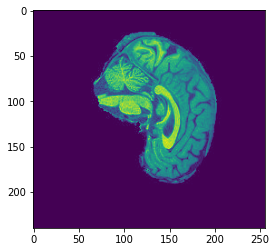

In [4]:
plt.imshow(a[0][0])